In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import scipy.special as sps
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, RocCurveDisplay)
from IPython.display import Image
from my_awesome_eda import run_eda

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

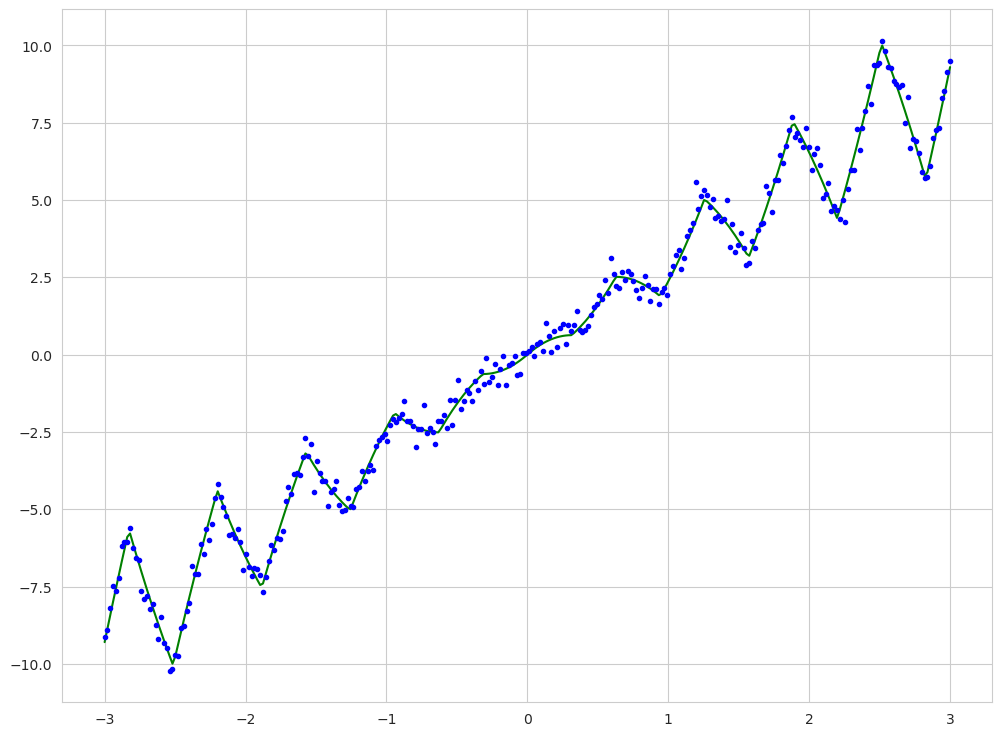

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y_noise = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "g");
plt.plot(X.reshape(-1), y_noise.reshape(-1), "b.")

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

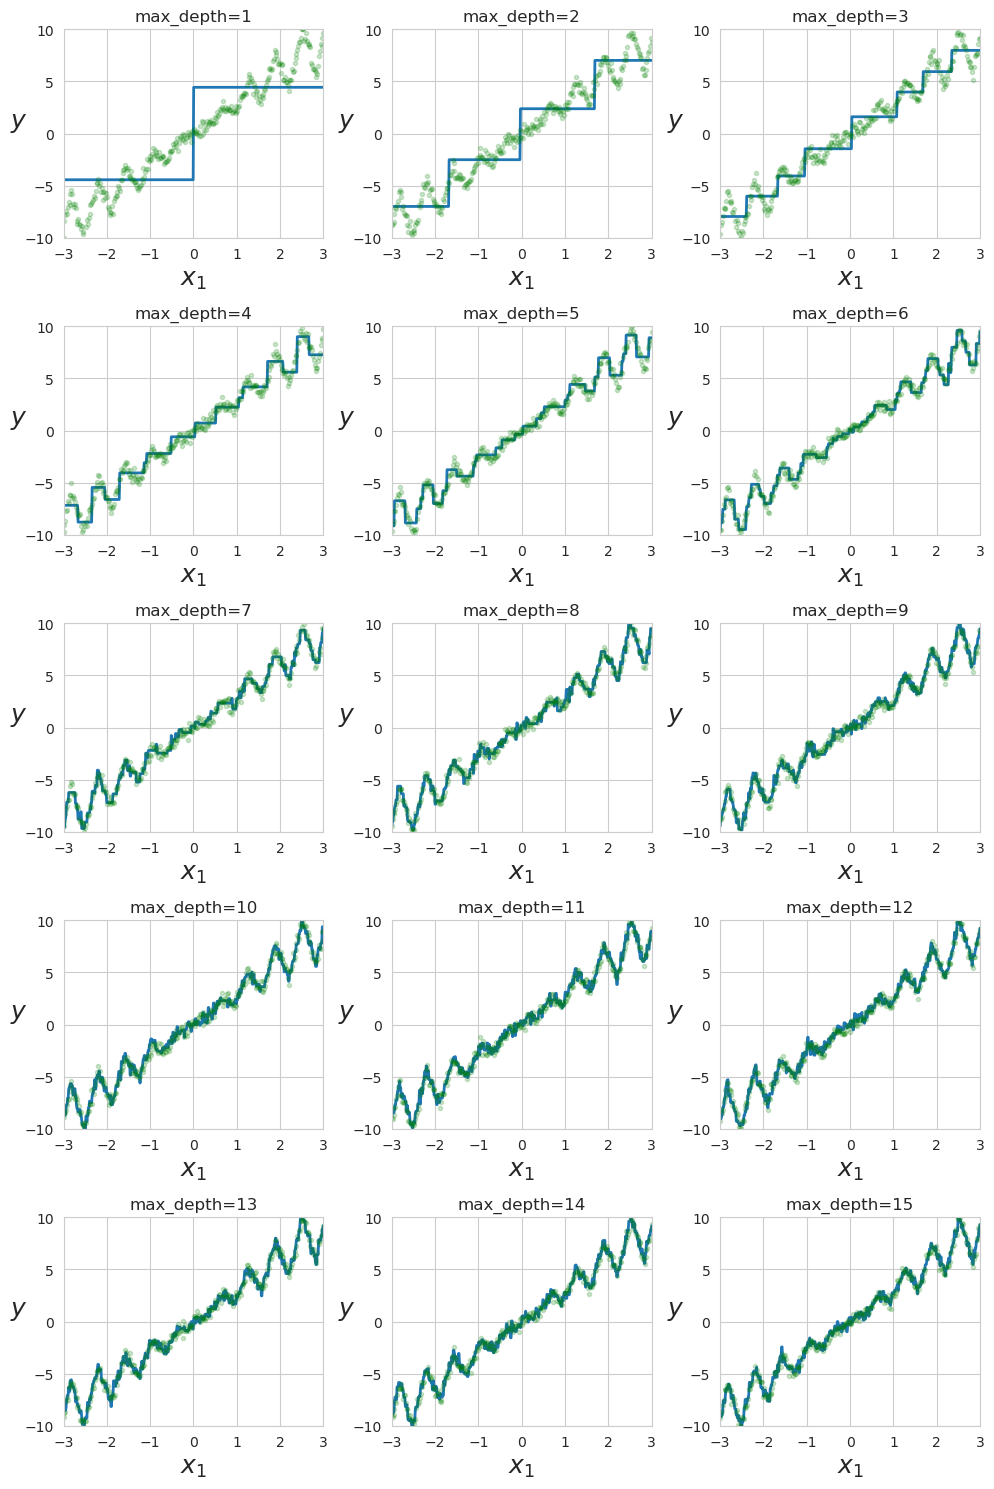

In [6]:
plt.figure(figsize=(10, 15))

for i in range(1, 16):
    plt.subplot(5, 3, i)
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y)
    y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
    y = y + np.random.randn(m, 1) / 3
    plt.plot(X.reshape(-1), y.reshape(-1), "g.", alpha=0.2)
    plt.title(f"max_depth={i}")

plt.tight_layout()
plt.show()

Где-то начиная с глубины 5 (или даже 4) дерево уже выглядит переобученным.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

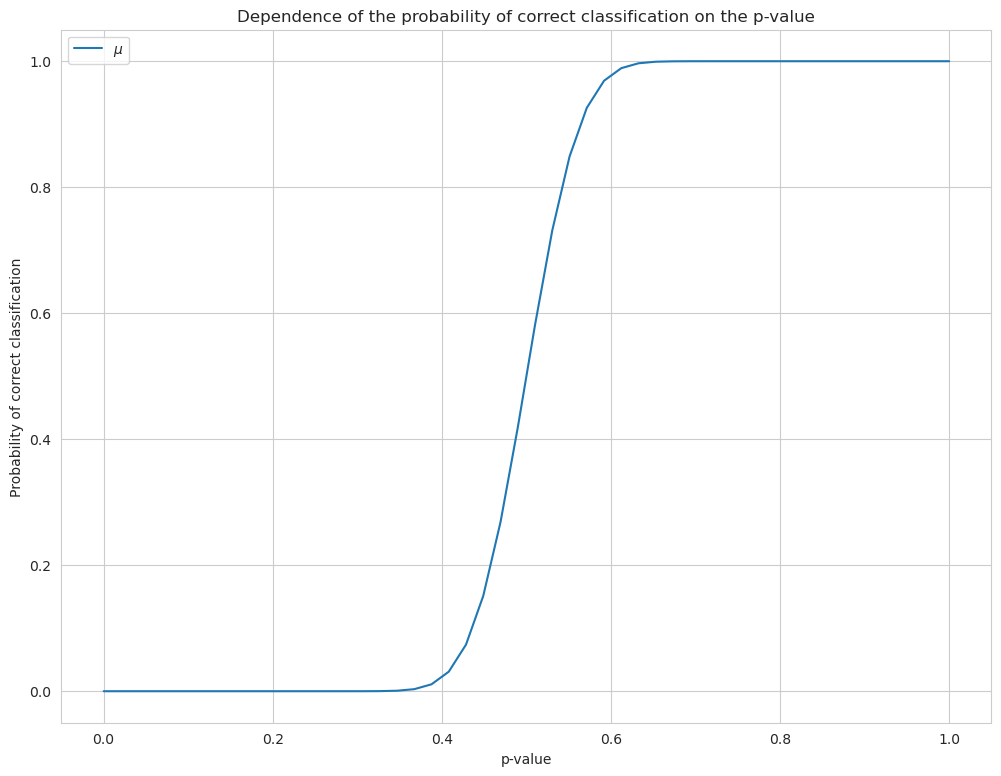

In [8]:
def compute_accuracy_probability(p):
    mu = np.sum(sps.comb(101, np.arange(51, 102)) * p**np.arange(51, 102) * (1-p)**np.arange(50, -1, -1))
    return mu

p_values = np.linspace(0, 1, 50)

accuracy_probabilities = [compute_accuracy_probability(p) for p in p_values]

plt.plot(p_values, accuracy_probabilities, label=r'$\mu$')
plt.xlabel('p-value')
plt.ylabel('Probability of correct classification')
plt.title('Dependence of the probability of correct classification on the p-value')
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

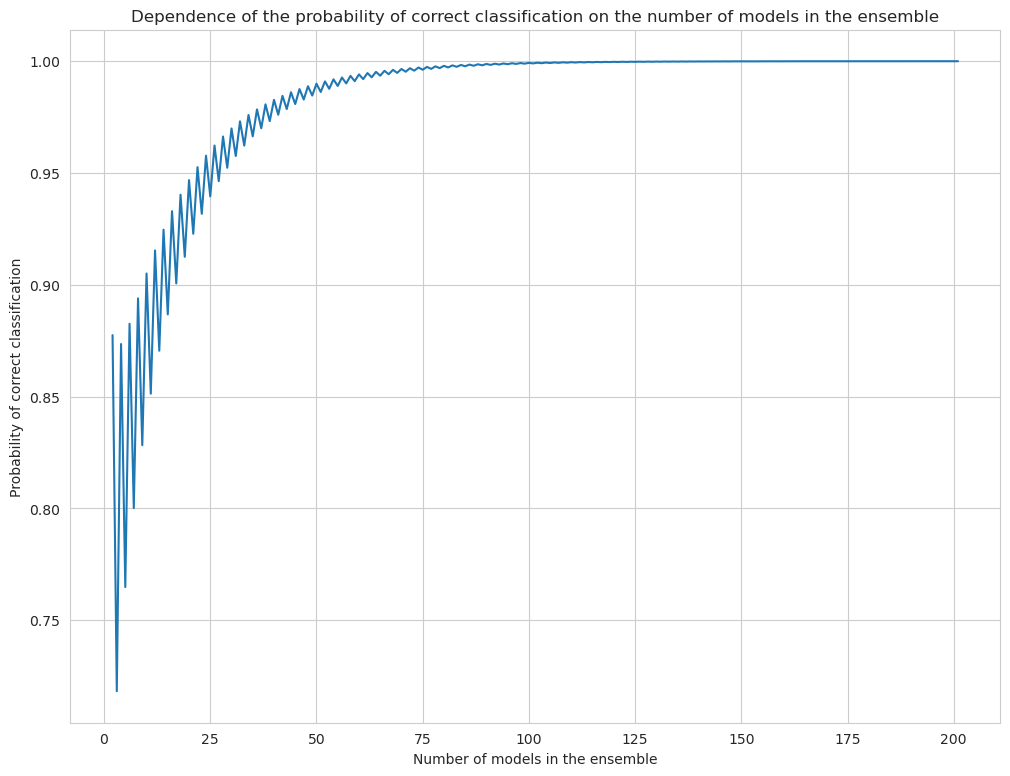

In [10]:
p = 0.65

def compute_ensemble_accuracy_probability(n):
    k_values = range(n // 2 + n % 2, n + 1)
    probabilities = [sps.comb(n, k) * p**k * (1-p)**(n-k) for k in k_values]
    return sum(probabilities)

ensemble_sizes = np.linspace(2, 201, 200).astype(int)

ensemble_probabilities = [compute_ensemble_accuracy_probability(n) for n in ensemble_sizes]

plt.plot(ensemble_sizes, ensemble_probabilities)
plt.xlabel('Number of models in the ensemble')
plt.ylabel('Probability of correct classification')
plt.title('Dependence of the probability of correct classification on the number of models in the ensemble')
plt.show()

Опишите ваши наблюдения:

* Даже если дерево правильно классифицирует с вероятностью 0,65, ансамбль деревьев показывает неплохие результаты
* Чем больше деревьев, тем меньше разброс вероятности правильной классификации на каждый шаг
* Чтобы совсем хорошо классифицировать, в ансамбле должно быть около 100 моделей, на крайний случай, если будет сложность с вычислением - от 75 моделей.

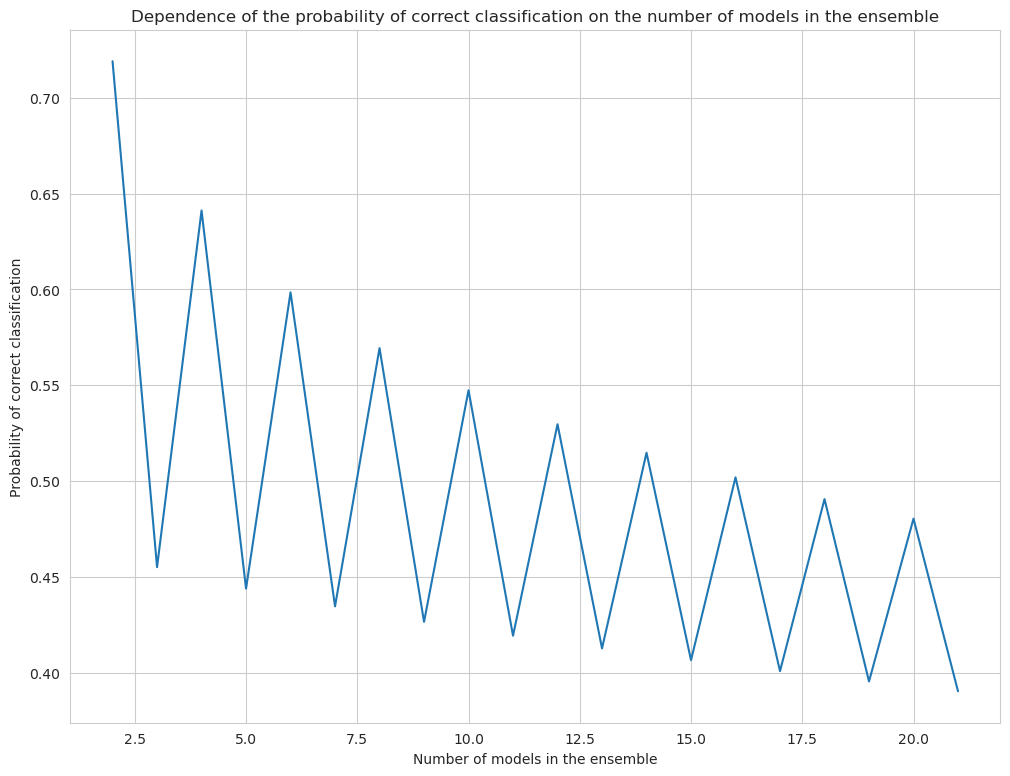

In [11]:
p = 0.47

def compute_ensemble_accuracy_probability(n):
    k_values = range(n // 2 + n % 2, n + 1)
    probabilities = [sps.comb(n, k) * p**k * (1-p)**(n-k) for k in k_values]
    return sum(probabilities)

ensemble_sizes = np.linspace(2, 21, 20).astype(int)

ensemble_probabilities = [compute_ensemble_accuracy_probability(n) for n in ensemble_sizes]

plt.plot(ensemble_sizes, ensemble_probabilities)
plt.xlabel('Number of models in the ensemble')
plt.ylabel('Probability of correct classification')
plt.title('Dependence of the probability of correct classification on the number of models in the ensemble')
plt.show()

Тут я просто хотела посмотреть что будет, если посадить лес из "глупеньких" деревьев. Таких больше двух лучше не сажать, судя по графику)

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [12]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            feature_idx = np.random.choice(n_features, size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feature_idx)
            
            bootstrap_idx = np.random.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap = X[bootstrap_idx]
            y_bootstrap = y[bootstrap_idx]
            
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state + i
            )
            tree.fit(X_bootstrap[:,  self.feat_ids_by_tree[i]], y_bootstrap)
            self.trees.append(tree)
        return self

    def predict_proba(self, X):
        probas = 0
        for i, tree in enumerate(self.trees):
            probas += tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
        avg_probas = probas / self.n_estimators
        return avg_probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [13]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ff7f50", "#20b2aa", "#c7fcec"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ff7f50", "#87ceeb", "#c7fcec"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "o", color="#ff7f50", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "s", color="#20b2aa", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

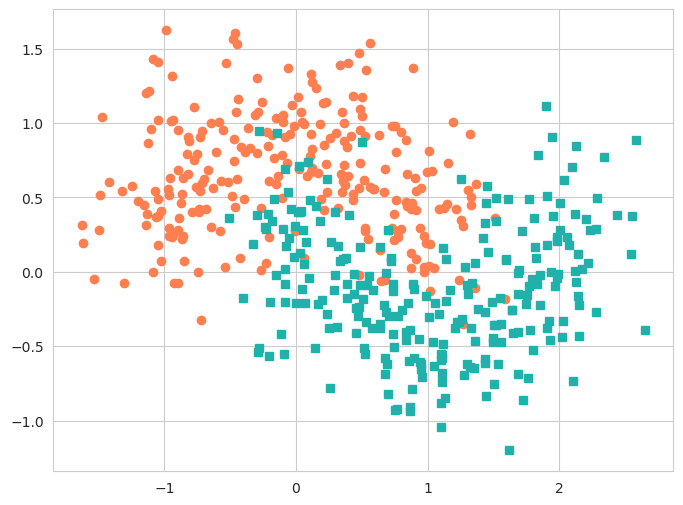

In [14]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "o", color="#ff7f50")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "s", color="#20b2aa")
plt.show()

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

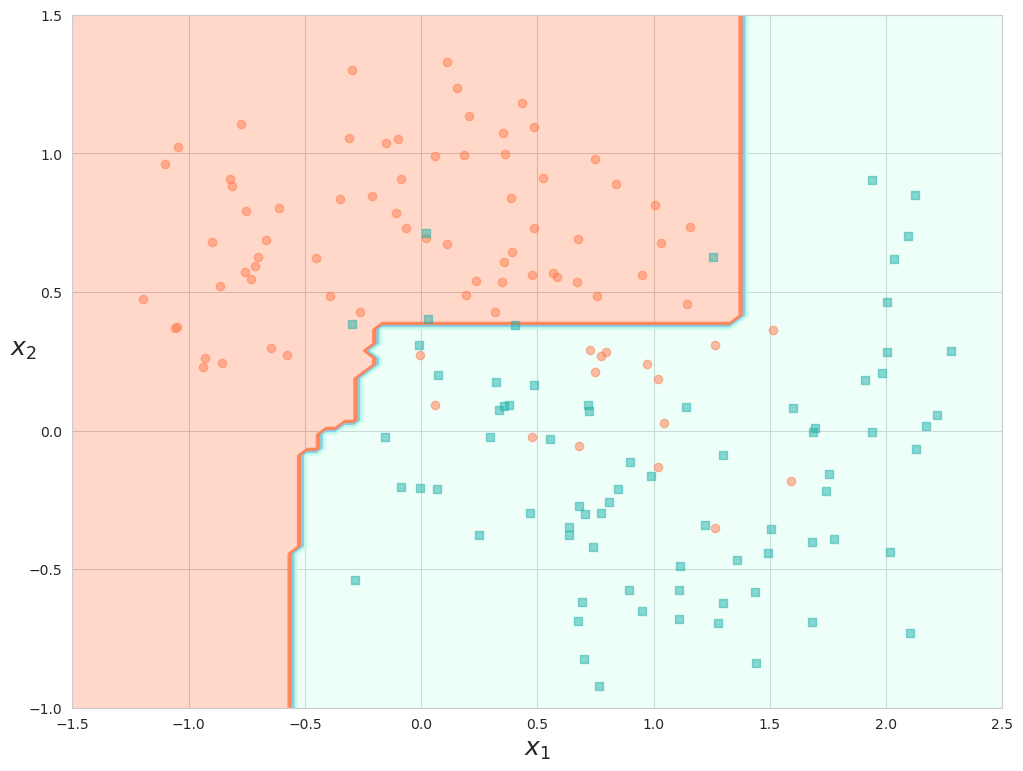

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

cls = RandomForestClassifierCustom(max_depth=3, n_estimators=100, max_features=2)
cls.fit(X_train, y_train)
plot_decision_boundary(cls, X_test, y_test)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

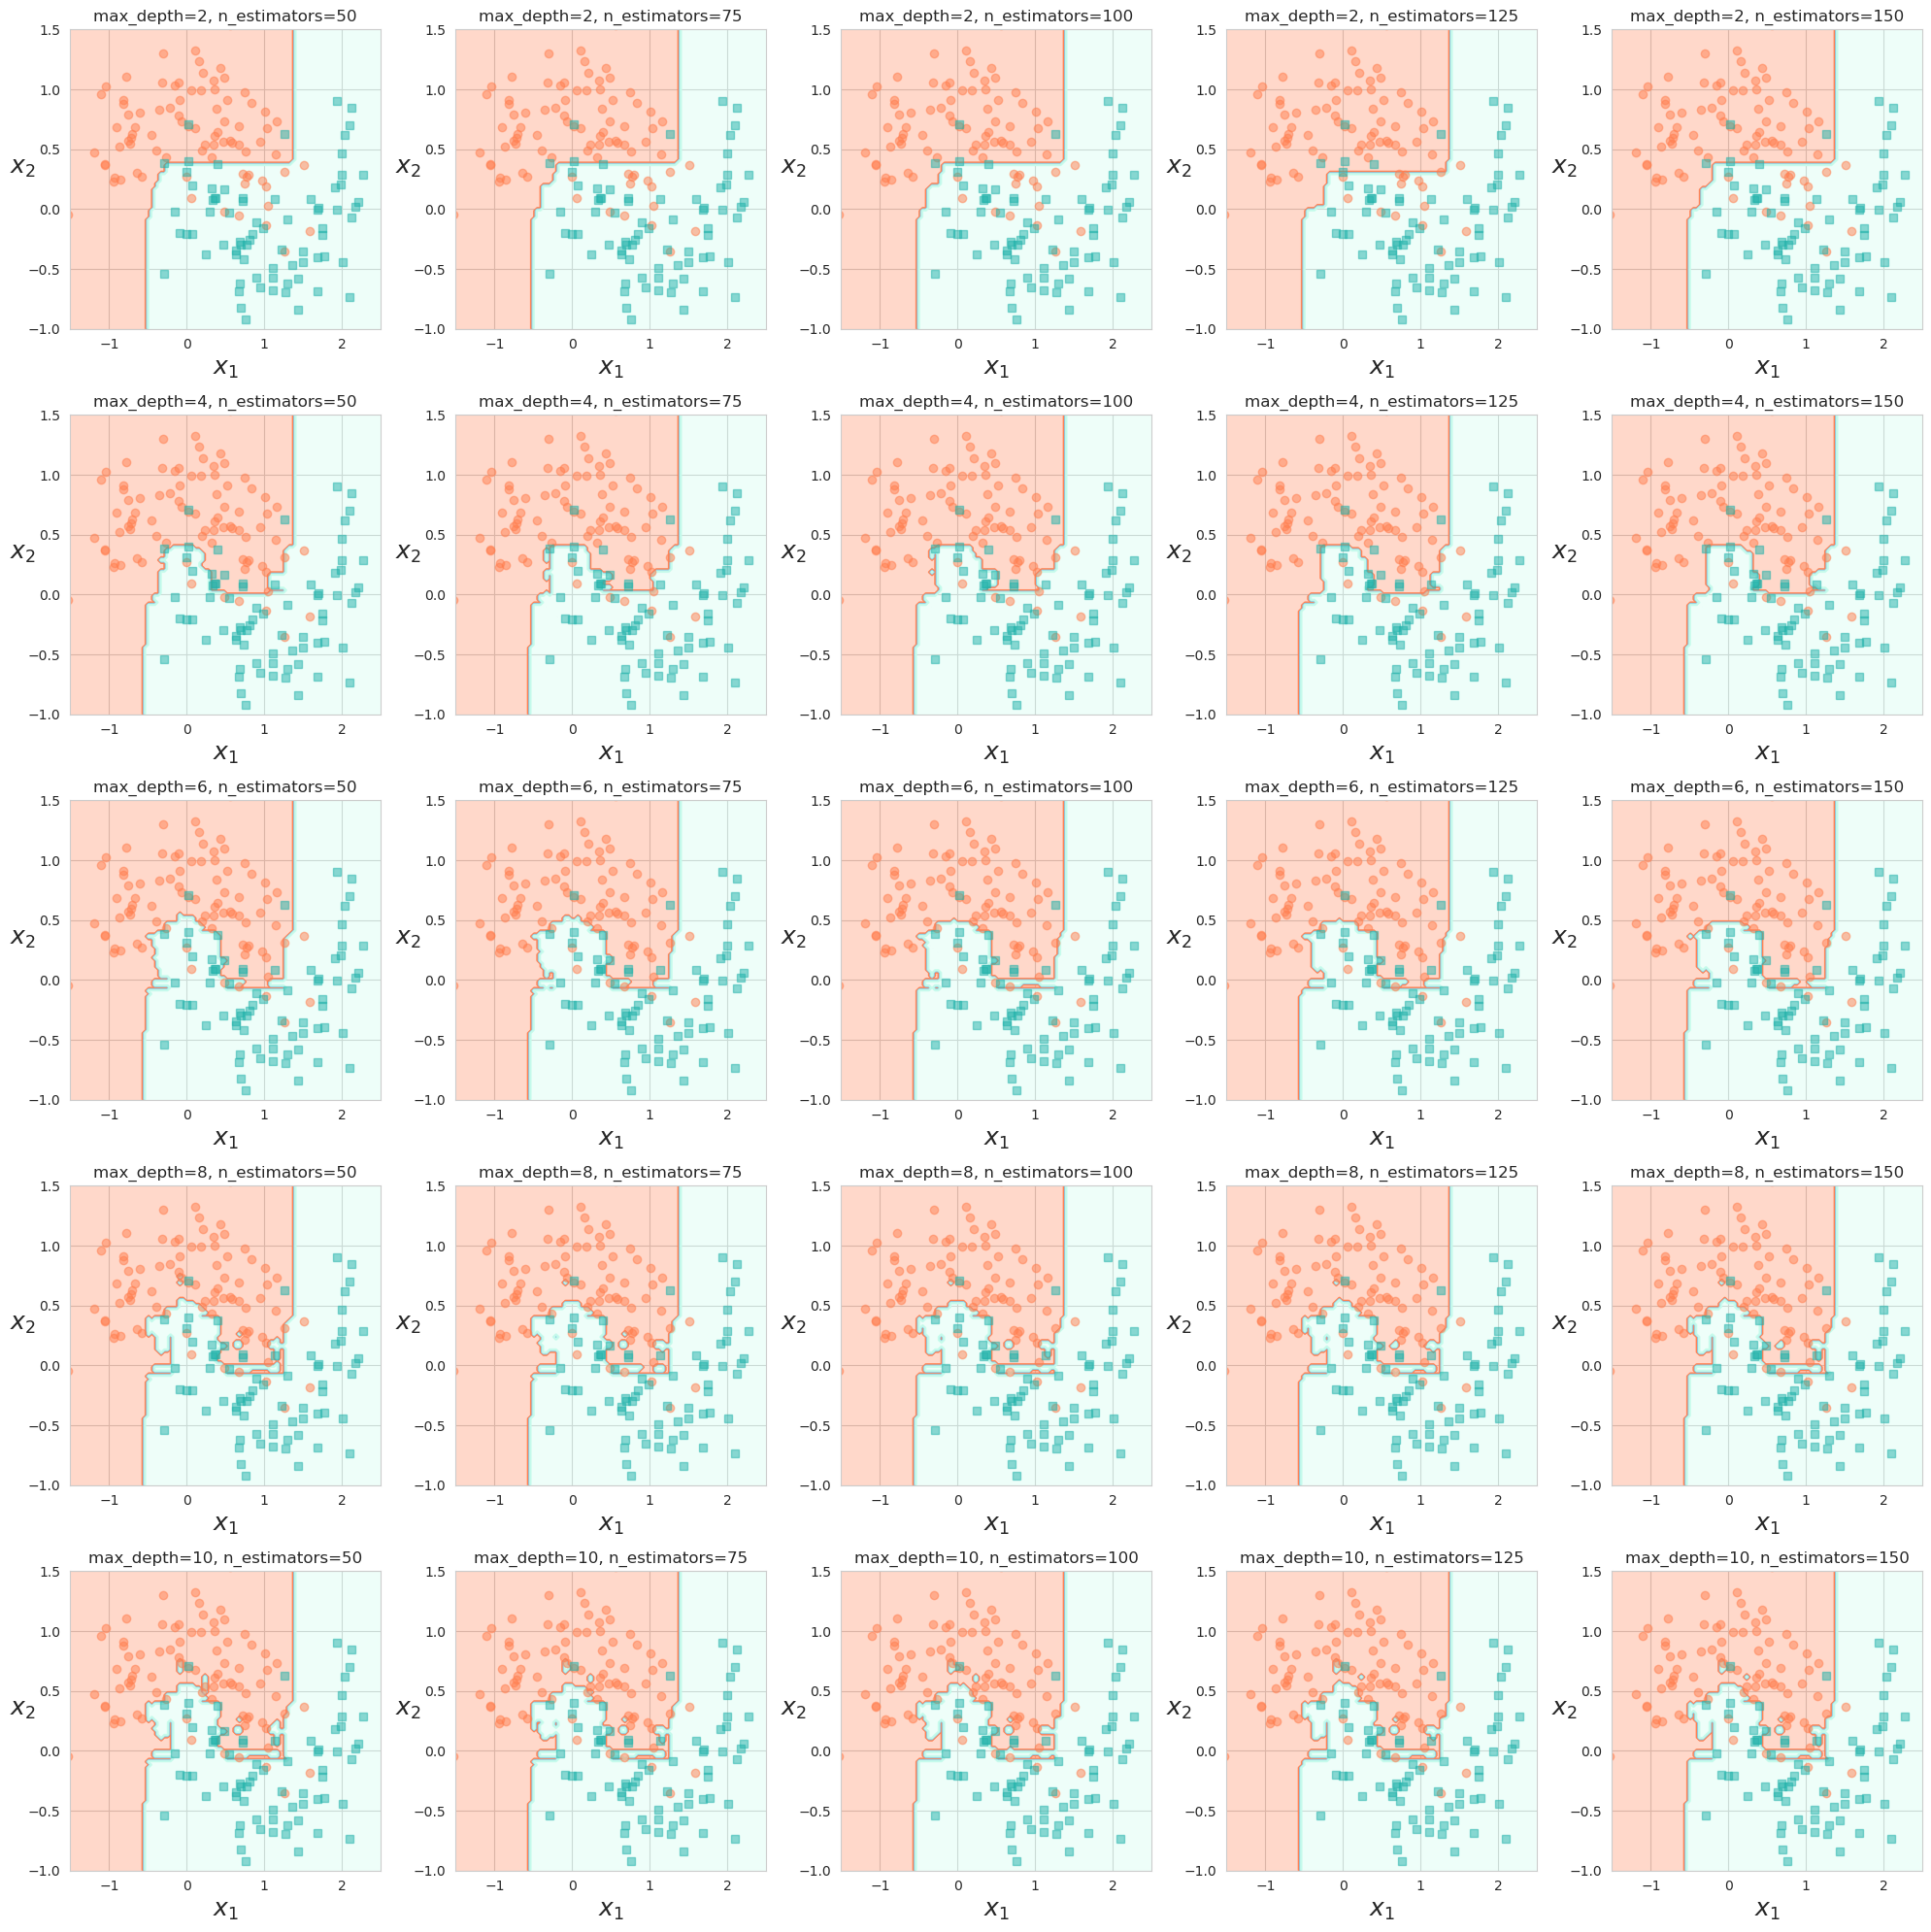

In [18]:
plt.figure(figsize=(20, 20))
idx = 1

for depth in range(2, 11, 2):
    for n_estimators in range(50, 151, 25):
        cls = RandomForestClassifierCustom(max_depth=depth, n_estimators=n_estimators, max_features=2)
        cls.fit(X_train, y_train)
        plt.subplot(5, 5, idx)
        plot_decision_boundary(cls, X_test, y_test)
        plt.title(f"max_depth={depth}, n_estimators={n_estimators}")
        idx += 1

plt.tight_layout()
plt.show()

Где эта тонкая грань? Вот 2 мне еще не нравится, а 4 - уже не нравится, начинаются какие-то непонятные рваные границы. Вот разве что глебина 4 и количество 150 более или менее хорошо.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [19]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [20]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
X.shape

(569, 30)

In [22]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

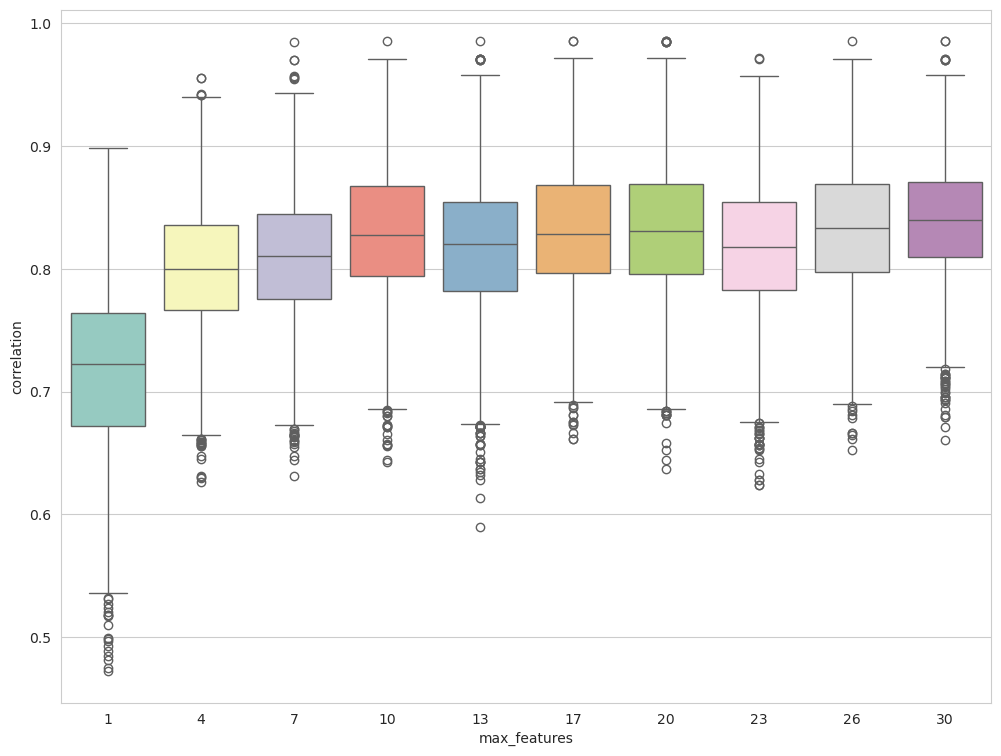

In [23]:
max_features_values = np.linspace(1, 30, 10).astype(int)
correlation_values = []

for max_features in max_features_values:
    rf_cls = RandomForestClassifier(max_features=max_features)
    rf_cls.fit(X_train, y_train)
    correlations = base_model_pair_correlation(rf_cls, X_test)
    correlation_values.append(correlations)

corr_df = pd.DataFrame({'max_features': max_features_values, 'correlation': correlation_values})
corr_df = corr_df.explode('correlation')

sns.boxplot(x='max_features', y='correlation', data=corr_df, palette='Set3')
plt.xlabel('max_features')
plt.ylabel('correlation')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

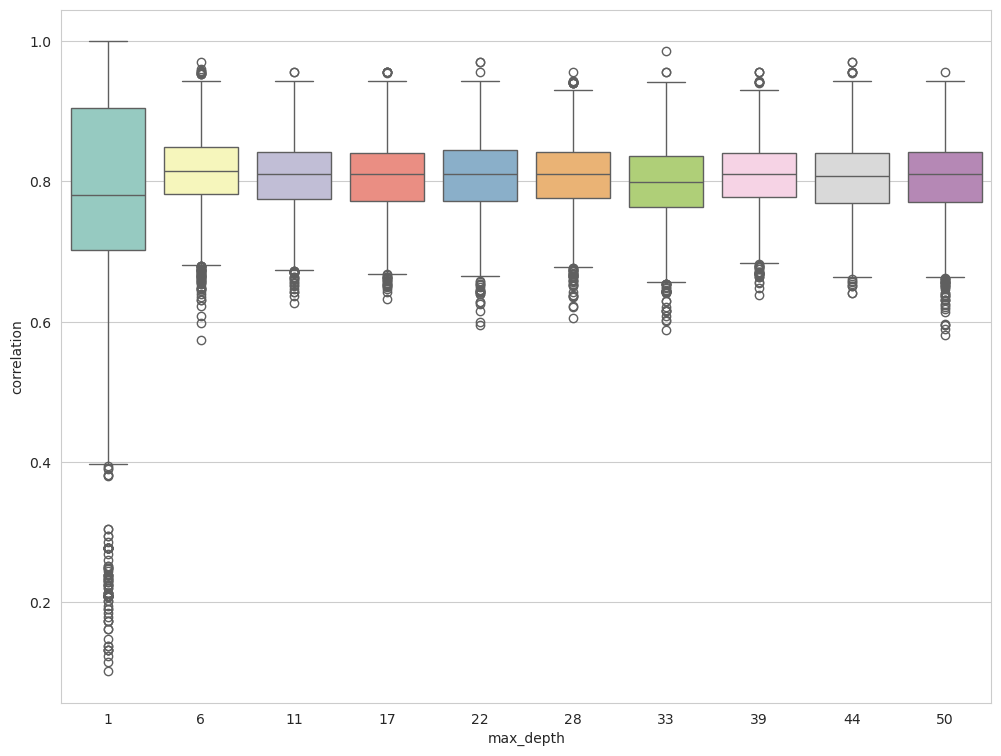

In [25]:
max_depth_values = np.linspace(1, 50, 10).astype(int)
correlation_values = []

for max_depth in max_depth_values:
    rf_cls = RandomForestClassifier(max_depth=max_depth)
    rf_cls.fit(X_train, y_train)
    correlations = base_model_pair_correlation(rf_cls, X_test)
    correlation_values.append(correlations)

corr_df = pd.DataFrame({'max_depth': max_depth_values, 'correlation': correlation_values})
corr_df = corr_df.explode('correlation')

sns.boxplot(x='max_depth', y='correlation', data=corr_df, palette='Set3')
plt.xlabel('max_depth')
plt.ylabel('correlation')
plt.show()

Опишите ваши наблюдения:

* При увеличении значения max_features корреляция между базовыми моделями увеличивается, но с определенного момента колеблется вокруг 0.85 (с 10 фич в этом случае, всего у нас 10 в этом датасете).
* При увеличении значения max_depth корреляция между базовыми моделями увеличивается, но с определенного момента колеблется вокруг 0.8, примерно как с фичами. При глубине 1 очень большой разброс, такую глубину лучше не использовать.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [26]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data_folder/raw_data/heart.csv")

In [27]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [28]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, verbose=-1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [29]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.817010631644778
XGBRFClassifier: 0.8499478840942256
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8494440278941667
VotingClassifier: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [30]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)

        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))

    return corrs

In [31]:
for name, model in base_models:
    model.fit(X_train, y_train)

voting_hard_cls = VotingClassifier(estimators=base_models, voting='hard')
voting_hard_cls.fit(X_train, y_train)

voting_soft_cls = VotingClassifier(estimators=base_models, voting='soft')
voting_soft_cls.fit(X_train, y_train)

hard_voting_correlations = base_model_pair_correlation_for_voting_clf(voting_hard_cls, X)
soft_voting_correlations = base_model_pair_correlation_for_voting_clf(voting_soft_cls, X)

In [32]:
for est1, est2, correlation in hard_voting_correlations:
    print(f"Correlation between {est1.__class__.__name__} and {est2.__class__.__name__}: {correlation}")

Correlation between DecisionTreeClassifier and RandomForestClassifier: 0.8593237278777583
Correlation between DecisionTreeClassifier and ExtraTreesClassifier: 0.7939480300580531
Correlation between DecisionTreeClassifier and KNeighborsClassifier: 0.7356706024980413
Correlation between DecisionTreeClassifier and SVC: 0.8125152591475469
Correlation between DecisionTreeClassifier and SVC: 0.5049441062502102
Correlation between DecisionTreeClassifier and CatBoostClassifier: 0.8593484479587904
Correlation between DecisionTreeClassifier and LGBMClassifier: 0.8560848217397437
Correlation between DecisionTreeClassifier and LGBMClassifier: 0.9086485866345925
Correlation between DecisionTreeClassifier and XGBClassifier: 0.8325828591778619
Correlation between DecisionTreeClassifier and XGBRFClassifier: 0.9380372471490831
Correlation between DecisionTreeClassifier and LogisticRegression: 0.8365610052662212
Correlation between DecisionTreeClassifier and GaussianNB: 0.7643270715204763
Correlation be

In [33]:
for est1, est2, correlation in soft_voting_correlations:
    print(f"Correlation between {est1.__class__.__name__} and {est2.__class__.__name__}: {correlation}")

Correlation between DecisionTreeClassifier and RandomForestClassifier: 0.8593237278777583
Correlation between DecisionTreeClassifier and ExtraTreesClassifier: 0.7939480300580531
Correlation between DecisionTreeClassifier and KNeighborsClassifier: 0.7356706024980413
Correlation between DecisionTreeClassifier and SVC: 0.8125152591475469
Correlation between DecisionTreeClassifier and SVC: 0.5049441062502102
Correlation between DecisionTreeClassifier and CatBoostClassifier: 0.8593484479587904
Correlation between DecisionTreeClassifier and LGBMClassifier: 0.8560848217397437
Correlation between DecisionTreeClassifier and LGBMClassifier: 0.9086485866345925
Correlation between DecisionTreeClassifier and XGBClassifier: 0.8325828591778619
Correlation between DecisionTreeClassifier and XGBRFClassifier: 0.9380372471490831
Correlation between DecisionTreeClassifier and LogisticRegression: 0.8365610052662212
Correlation between DecisionTreeClassifier and GaussianNB: 0.7643270715204763
Correlation be

In [34]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Руками во всем этом ковыряться я не очень хочу, написала маленький цикл

In [35]:
all_estimators = base_models
threshold = 0.87
over_th = []

#for n in [n for n in range(1, 13)]: too long
for n in [2, 3, 4, 5, 7]:
    combos = list(combinations(all_estimators, n))
    for combination in combos:
        combination_list = list(combination)
        for voting in ['soft', 'hard']:
            voting_cls = VotingClassifier(estimators=combination_list, voting=voting, n_jobs=-1)
            voting_cls.fit(X_train, y_train)
            scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1")
            if scores.mean() > threshold:
                over_th.append((scores.mean(), combination_list, voting))
                if len(over_th) == 1: # хоть одну модельку давай найдем, мой хороший
                    break

NameError: name 'result' is not defined

In [55]:
print("Over the thrashhold:")
for result in over_th:
    print(f"F1: {result[0]}")
    print(f"Combination: {result[1]}")
    print(f"Voting: {result[2]}")

Over the thrashhold:
F1: 0.8733520288048746
Combination: [('SVC_RBF', SVC(probability=True, random_state=111)), ('XGB_RF', XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=111, reg_alpha=None, ...)), ('LR', LogisticRegression(max_iter=10000, solver='liblinear'))]
Voting: hard


Вот, получается хорошая комбинация SVC_RBF + XGB_RF + LR

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [38]:
data = pd.read_csv("../data_folder/raw_data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [39]:
column_names = data.columns.tolist()
print(column_names)

['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


Я честно пыталась найти описание датасета, но в итоге решила просто перевести название колонок:
* 'State' - штат,
* 'Account Length' - продолжительность счета? (что это?),
* 'Area Code' - код региона,
* 'Phone' - телефон,
* "Int'l Plan" - внктренний план/интернет план/ начальный план,
* 'VMail Plan' - план виртуальной почты,
* 'VMail Message' - сообщения виртуальной почты,
* 'Day Mins' - минут в день,
* 'Day Calls' - звонков в день,
* 'Day Charge' - дневная оплата,
* 'Eve Mins' - еще какие-то минуты,
* 'Eve Calls'- еще какие-то звонки,
* 'Eve Charge' - еще какая-то оплата,
* 'Night Mins' - ночные минуты,
* 'Night Calls' - ночные звонки,
* 'Night Charge' ночная оплата,
* 'Intl Mins' - междунарожные минуты (а тут почему нет ', это одно и то же слово?),
* 'Intl Calls' - международные звонки,
* 'Intl Charge' - международная оплата,
* 'CustServ Calls' - звонки в службу поддержки,
* 'Churn?' - отток? ушел или нет, наш таргет (зачем точки на конце?)

Давайте уберем все специальные символы, а потом посмотрим на данные, сделаем немного EDA

In [40]:
data = data.rename(columns={"Int'l Plan": "Intl Plan", "Churn?": "Churn"})
data['Churn'] = data['Churn'].str.replace('.', '')
data.head()

,State,Account Length,Area Code,Phone,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Praise the Omnissiah! Welcome to the Sanctum of Exploratory Data Analysis.

Number of Observations (Rows): 3333
Number of Parameters (Columns): 21

Data Types of Each Column:
State            object
Account Length   int64
Area Code        int64
Phone            object
Intl Plan        category
VMail Plan       category
VMail Message    int64
Day Mins         float64
Day Calls        int64
Day Charge       float64
Eve Mins         float64
Eve Calls        int64
Eve Charge       float64
Night Mins       float64
Night Calls      int64
Night Charge     float64
Intl Mins        float64
Intl Calls       int64
Intl Charge      float64
CustServ Calls   int64
Churn            category

Numerical features: Account Length, Area Code, VMail Message, Day Mins, Day Calls, Day Charge, Eve Mins, Eve Calls, Eve Charge, Night Mins, Night Calls, Night Charge, Intl Mins, Intl Calls, Intl Charge, CustServ Calls
String features: State, Phone
Categorical features: Intl Plan, VMail Plan, Churn

Counts and Fre

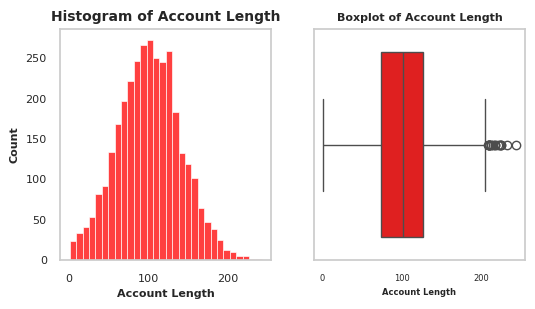

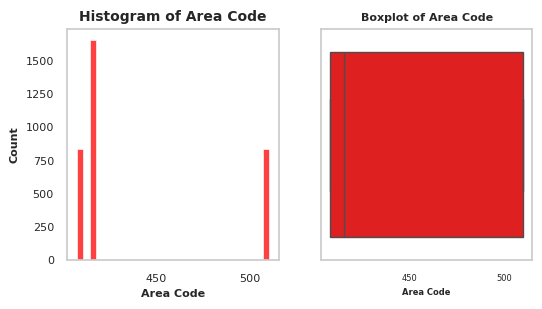

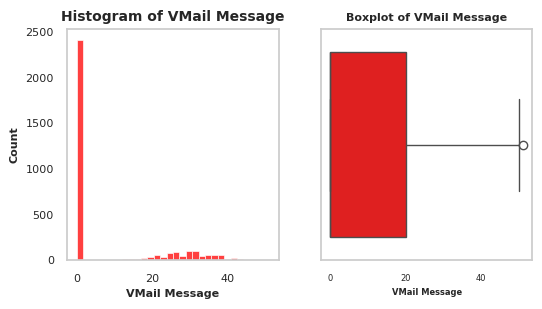

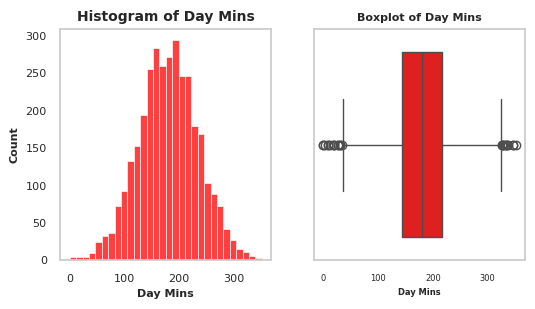

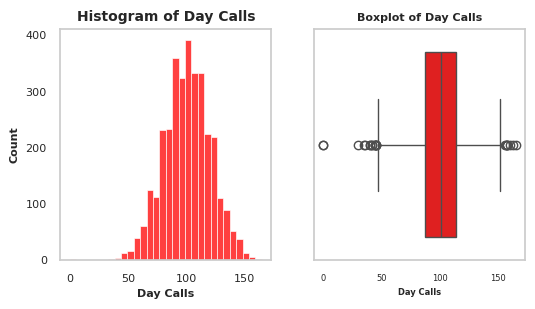

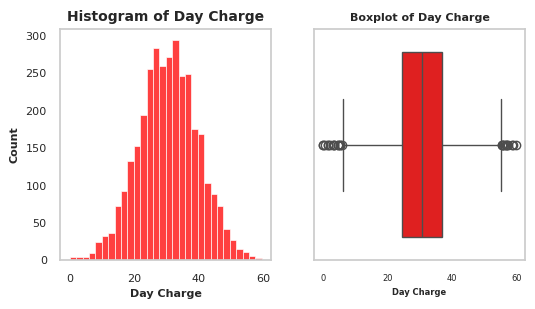

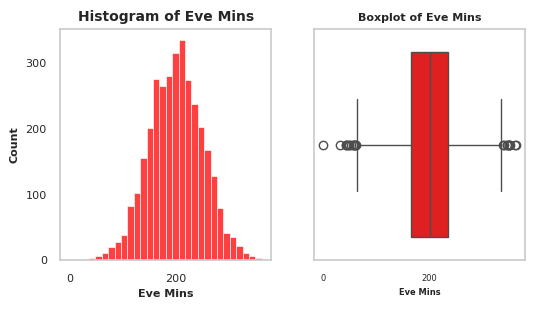

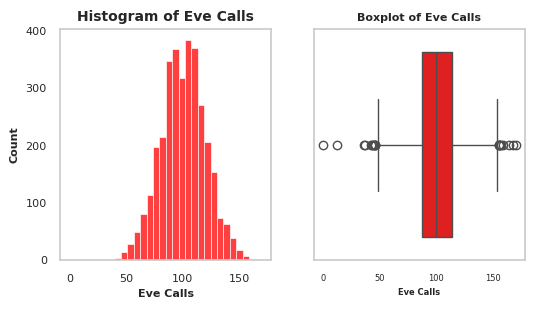

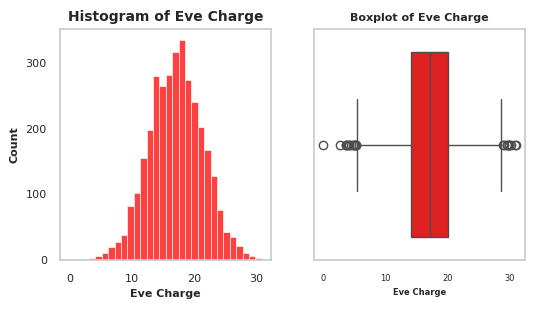

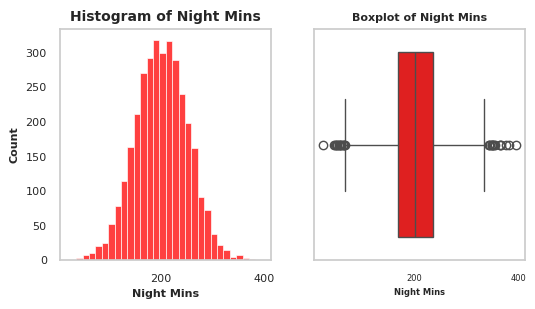

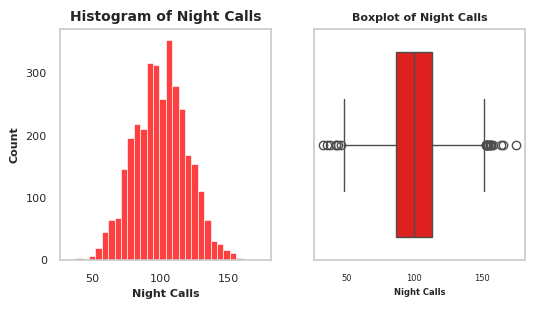

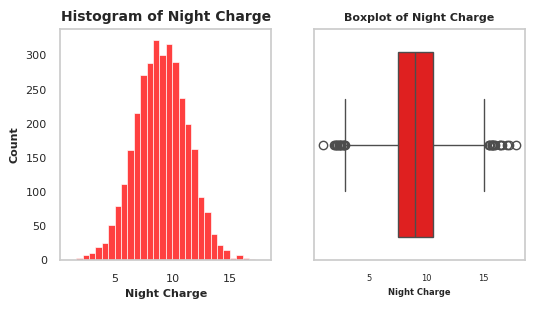

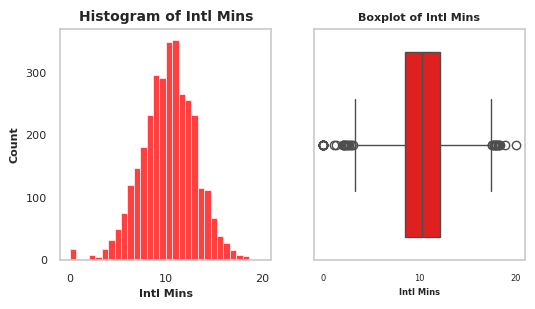

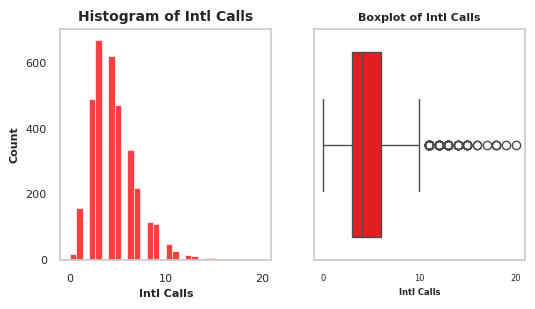

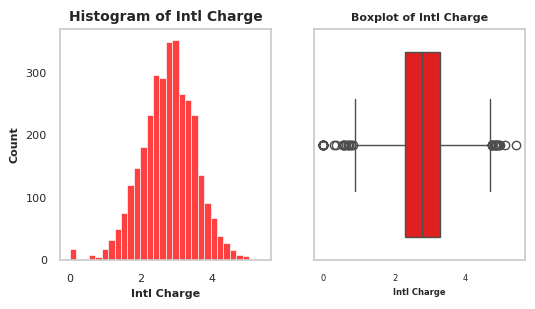

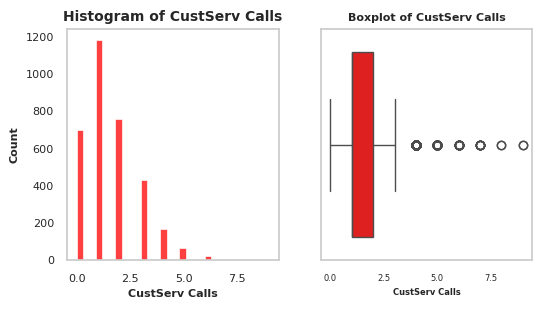


Correlation Heatmap:


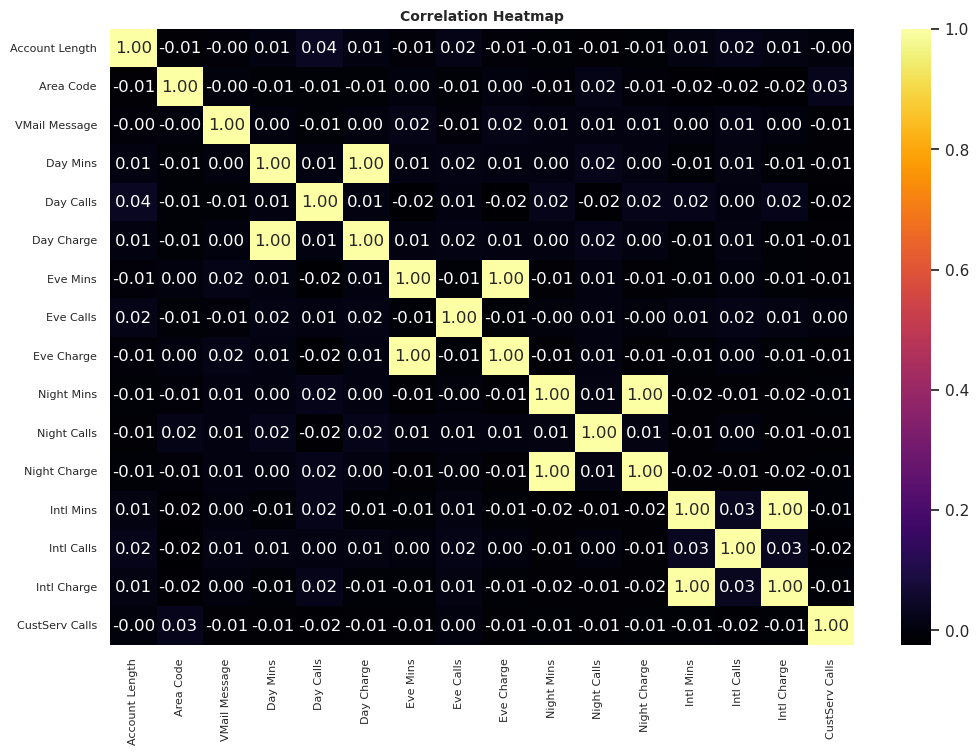


Outliers for Numerical Features:
Account Length: 18
Area Code: 0
VMail Message: 1
Day Mins: 25
Day Calls: 23
Day Charge: 25
Eve Mins: 24
Eve Calls: 20
Eve Charge: 24
Night Mins: 30
Night Calls: 22
Night Charge: 30
Intl Mins: 46
Intl Calls: 78
Intl Charge: 49
CustServ Calls: 267

Missing Values:
Total Missing Values: 0
Rows with Missing Values: 0
Columns with Missing Values: 

Missing Values Proportion:


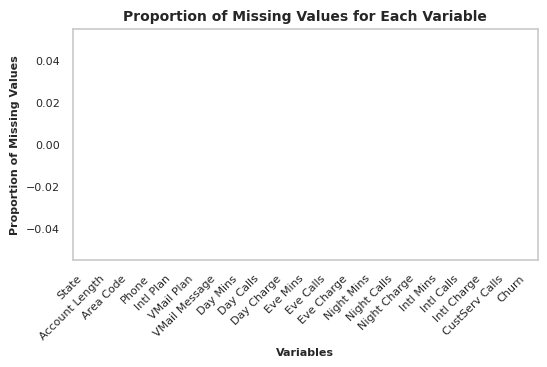


Duplicate Rows:
Number of Duplicate Rows: 0

May the data guide you, and the Omnissiah bless your analysis.


In [41]:
run_eda(data, category_values=2)

Если совсем коротко - у нас много наблюдений, есть дисбаланс в таргете, нет пропущенных значений, есть фичи со стопроцентной корреляцией, оно и логично - чем больше минур разговаривашь, тем больше платишь, давайте оставим по одной из каждой группы). У фичи Area Code какое-то очень странное распределение, как у категориальной переменной, она может дублироваться со штатом, давайте оставим штат и будем его кодировать. Это может быть полезно - вдруг в каком-то штате плохая вышка или сильный конкурент. Номер телефона - это как ID клиента, у всех должен быть уникальный, можно погадать на телефонном номере про отток клиента в зависимости от количеств цифр 6 или 8 в номере, но как-нибудь в другой раз.

In [42]:
data['VMail Message'].unique() #какая-то не популярная штука со странным распределением

array([25, 26,  0, 24, 37, 27, 33, 39, 30, 41, 28, 34, 46, 29, 35, 21, 32,
       42, 36, 22, 23, 43, 31, 38, 40, 48, 18, 17, 45, 16, 20, 14, 19, 51,
       15, 11, 12, 47,  8, 44, 49,  4, 10, 13, 50,  9])

In [43]:
columns_to_drop = ['Area Code', 'Phone', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge']
data_cleaned = data.drop(columns_to_drop, axis = 1)

Praise the Omnissiah! Welcome to the Sanctum of Exploratory Data Analysis.

Number of Observations (Rows): 3333
Number of Parameters (Columns): 15

Data Types of Each Column:
State            object
Account Length   int64
Intl Plan        category
VMail Plan       category
VMail Message    int64
Day Mins         float64
Day Calls        int64
Eve Mins         float64
Eve Calls        int64
Night Mins       float64
Night Calls      int64
Intl Mins        float64
Intl Calls       int64
CustServ Calls   int64
Churn            category

Numerical features: Account Length, VMail Message, Day Mins, Day Calls, Eve Mins, Eve Calls, Night Mins, Night Calls, Intl Mins, Intl Calls, CustServ Calls
String features: State
Categorical features: Intl Plan, VMail Plan, Churn

Counts and Frequencies for Categorical Features:
           count  Frequency
Intl Plan                  
no          3010    0.90309
yes          323    0.09691
            count  Frequency
VMail Plan                  
no         

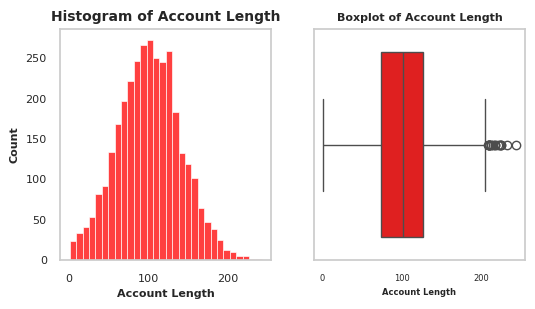

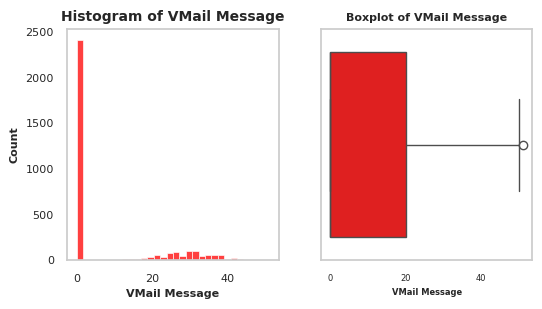

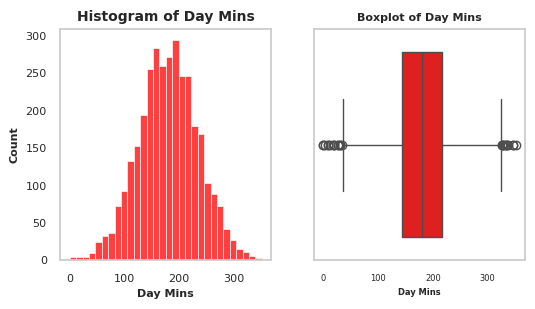

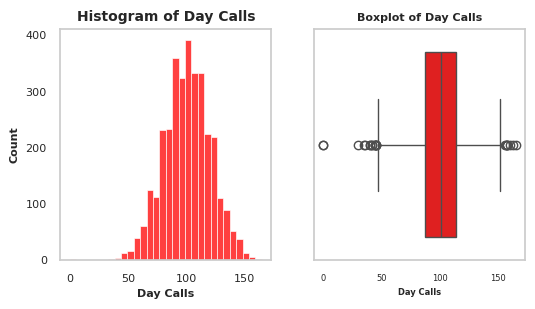

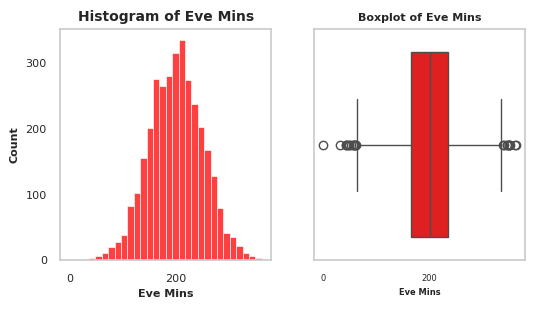

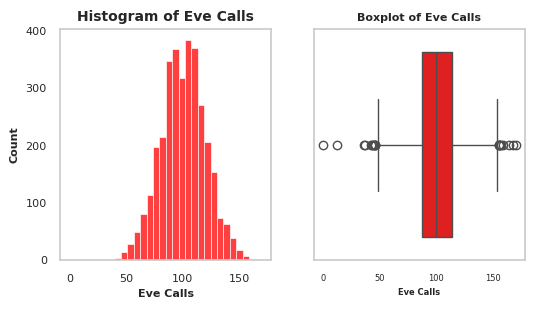

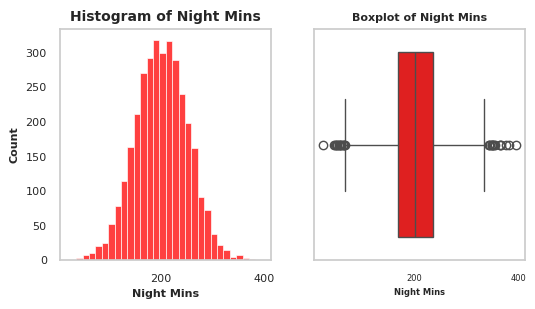

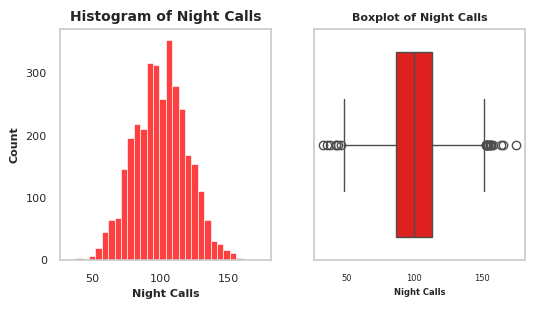

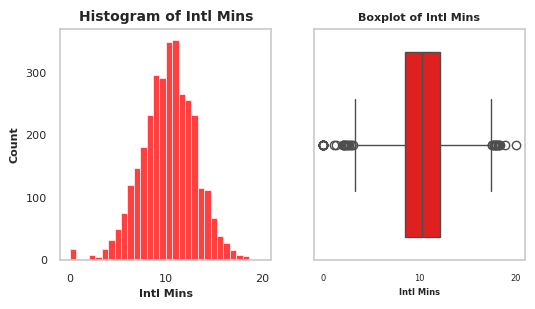

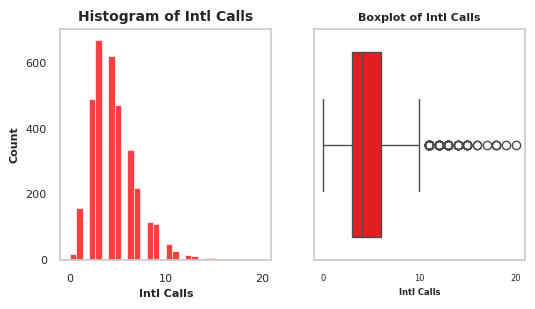

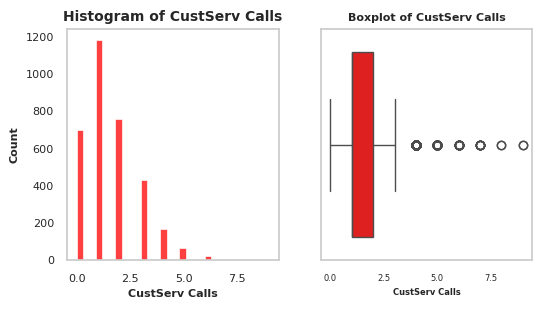


Correlation Heatmap:


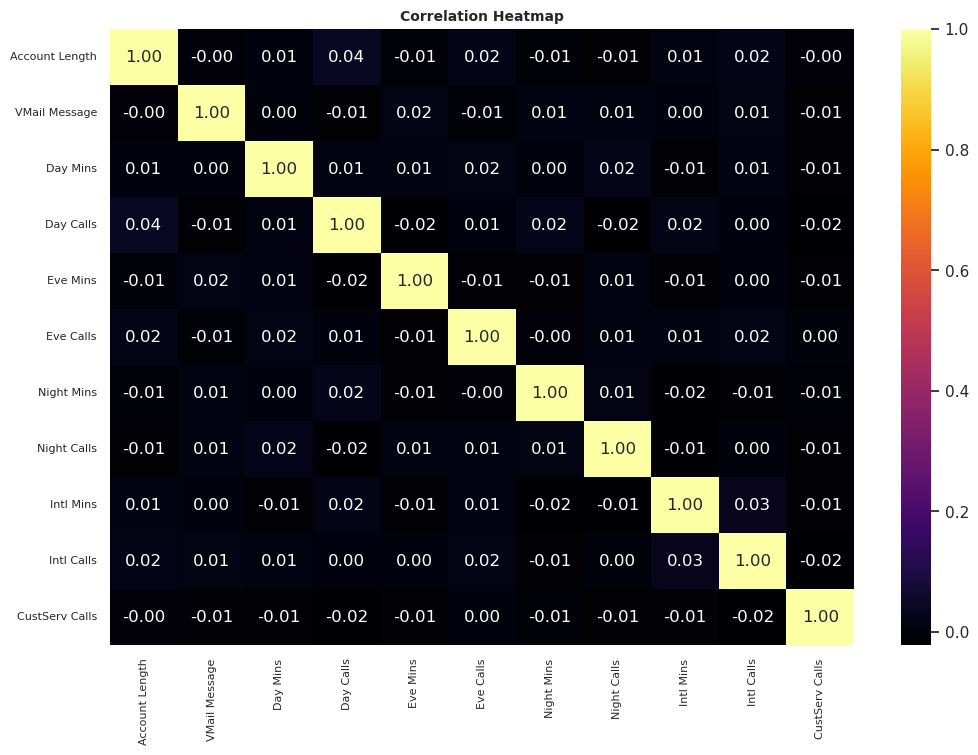


Outliers for Numerical Features:
Account Length: 18
VMail Message: 1
Day Mins: 25
Day Calls: 23
Eve Mins: 24
Eve Calls: 20
Night Mins: 30
Night Calls: 22
Intl Mins: 46
Intl Calls: 78
CustServ Calls: 267

Missing Values:
Total Missing Values: 0
Rows with Missing Values: 0
Columns with Missing Values: 

Missing Values Proportion:


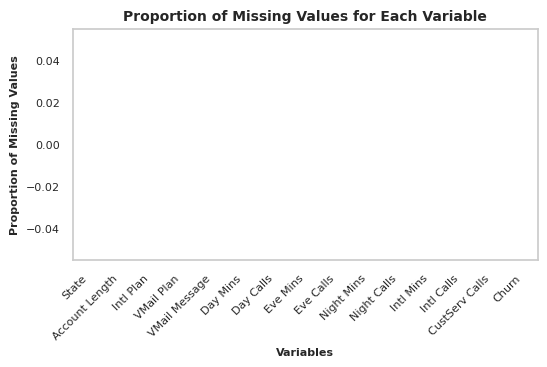


Duplicate Rows:
Number of Duplicate Rows: 0

May the data guide you, and the Omnissiah bless your analysis.


In [44]:
run_eda(data_cleaned, category_values=2)

Уже получше, давайте учить наши модели. Также сделаем препроцессинг, хотя бы потому что у нас тут минуты и разы в разных колонках, стандартизируем немного.

In [45]:
X = data_cleaned.drop(['Churn'], axis=1)
y = data_cleaned[['Churn']].replace({'False': 0, 'True': 1})
y = y.astype(bool)

num_cols = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins', 'Eve Calls',  'Night Mins', 'Night Calls', 'Intl Mins', 'Intl Calls', 'CustServ Calls']
cat_cols = ['State', 'Intl Plan', 'VMail Plan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [46]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(drop='first'), cat_cols)
])

preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Account Length', 'VMail Message', 'Day Mins',
                                  'Day Calls', 'Eve Mins', 'Eve Calls',
                                  'Night Mins', 'Night Calls', 'Intl Mins',
                                  'Intl Calls', 'CustServ Calls']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['State', 'Intl Plan', 'VMail Plan'])])

Выберите 2 модели — один случайный лес и один бустинг из приведенных ниже:

xgboost.XGBClassifier
xgboost.XGBRFClassifier — случайный лес от xgboost
lightgbm.LGBMClassifier
lightgbm.LGBMClassifier(boosting_type="rf") — случайный лес от lightgbm
catboost.CatBoostClassifier

Интересно - это по каким-то характеристикам или пальцем в небо? Давайте прогоним все в базовом варианте, а потом попробуем для парочки настроить гиперпараметры.

In [47]:
models = [
    ('XGBClassifier', xgboost.XGBClassifier()),
    ('XGBRFClassifier', xgboost.XGBRFClassifier()), # давайте возьмем вот этот рандом форест
    ('LGBMClassifier', lightgbm.LGBMClassifier()),
    #('LGBMRFClassifier', lightgbm.LGBMClassifier(boosting_type="rf")), с этим я не разобралась, он выдает ошибки
    ('CatBoostClassifier', catboost.CatBoostClassifier(verbose=False)) # и вот этот бустинг, у него хороший результат в базовом варианте 
]

for model_name, model in models:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f'F1-score of {model_name} = {round(f1, 3)}')

F1-score of XGBClassifier = 0.79
F1-score of XGBRFClassifier = 0.762
[LightGBM] [Info] Number of positive: 329, number of negative: 1904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1562
[LightGBM] [Info] Number of data points in the train set: 2233, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147335 -> initscore=-1.755654
[LightGBM] [Info] Start training from score -1.755654
F1-score of LGBMClassifier = 0.794
F1-score of CatBoostClassifier = 0.812


In [48]:
xgbrf = xgboost.XGBRFClassifier(random_state=SEED, n_jobs=-1)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgbrf)
])

params = {
    'model__n_estimators': [10, 50, 100],
    'model__max_depth': list(range(1, 51, 5)),
    'model__learning_rate': np.linspace(0.1, 0.5, 4),
    'model__max_leaves': [0, 10, 20, 30],
}

gscv = GridSearchCV(pipe, param_grid=params, cv=5, scoring='f1')
gscv.fit(X_train, y_train)

print("Best parameters:", gscv.best_params_)

Best parameters: {'model__learning_rate': 0.5, 'model__max_depth': 11, 'model__max_leaves': 0, 'model__n_estimators': 100}


In [49]:
y_pred = gscv.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

F1-score: 0.7376425855513308


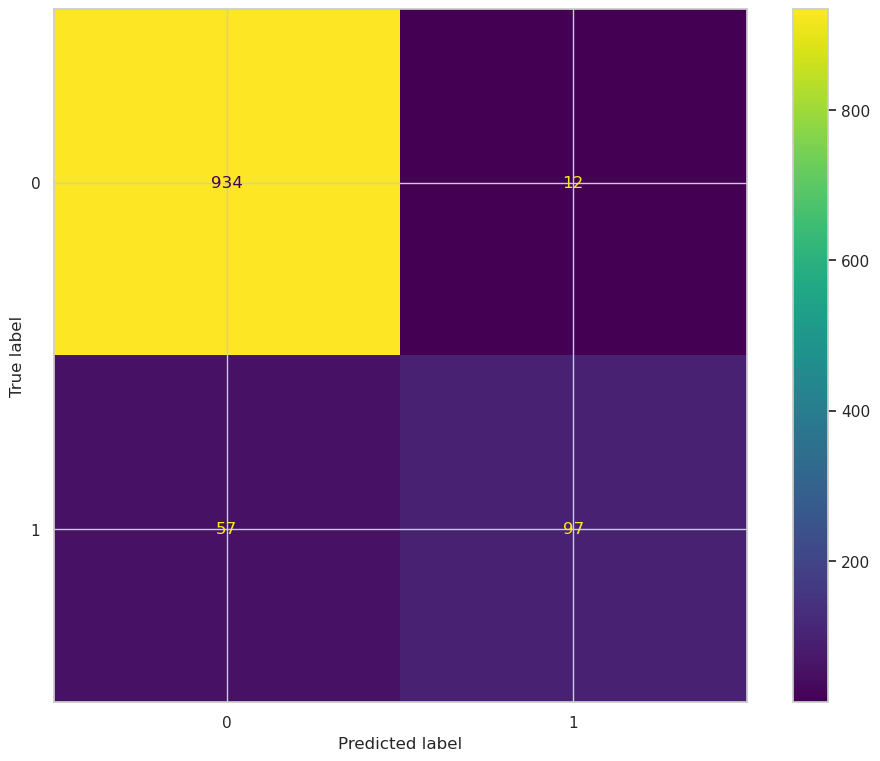

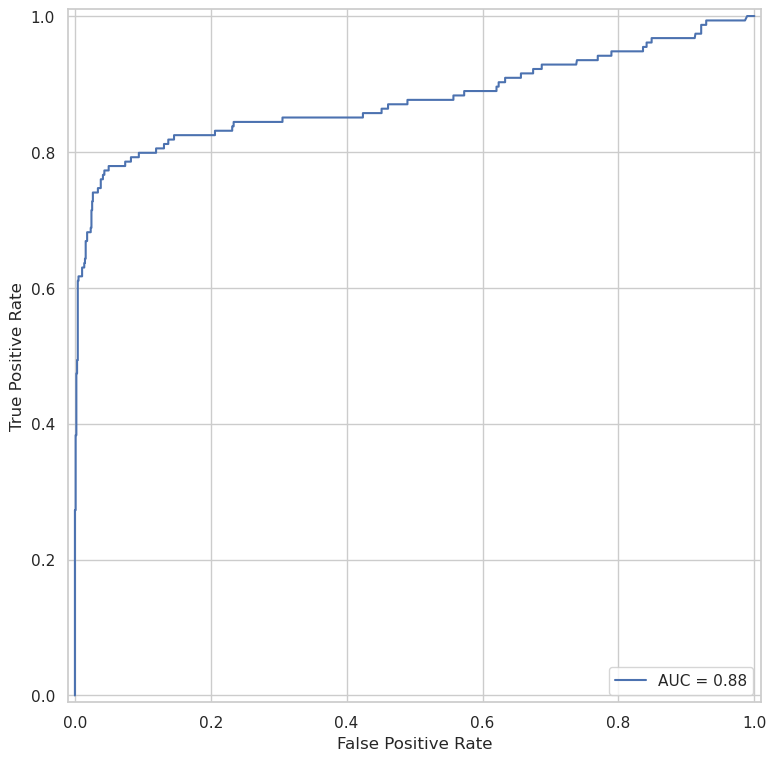

In [50]:
y_prob = gscv.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

In [51]:
catboost = catboost.CatBoostClassifier(random_state=SEED, verbose=False)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', catboost)])
params = {
    'model__iterations': [50, 100, 200, 300],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

gscv = GridSearchCV(pipe, param_grid=params, cv=5, scoring='f1')

gscv.fit(X_train, y_train)

print("Best parameters:", gscv.best_params_)

Best parameters: {'model__depth': 6, 'model__iterations': 200, 'model__learning_rate': 0.3}


In [56]:
y_pred = gscv.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

F1-score: 0.7870036101083032


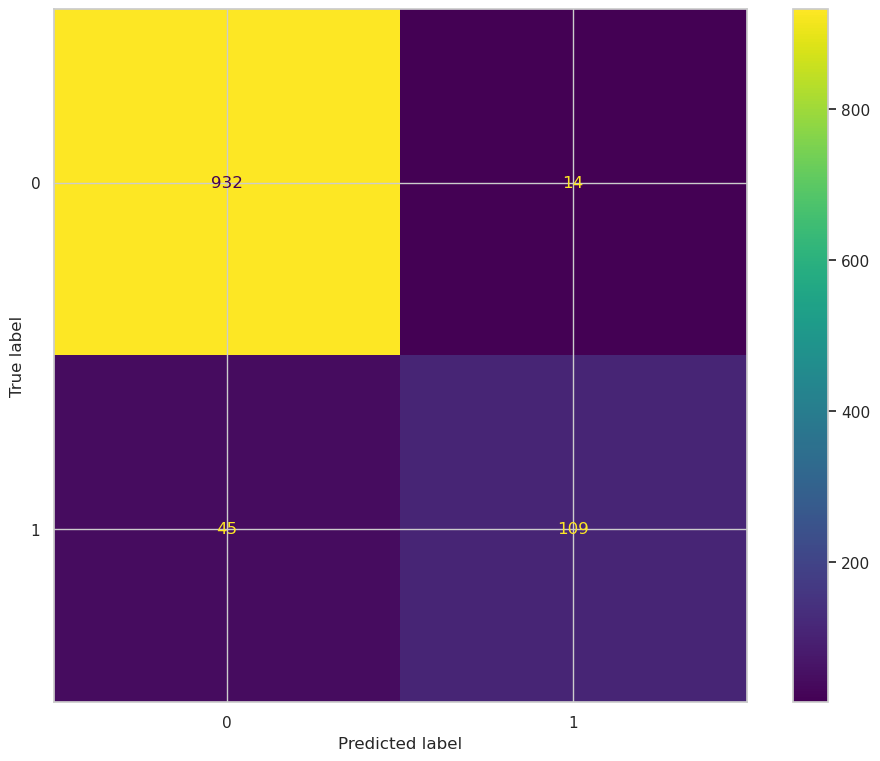

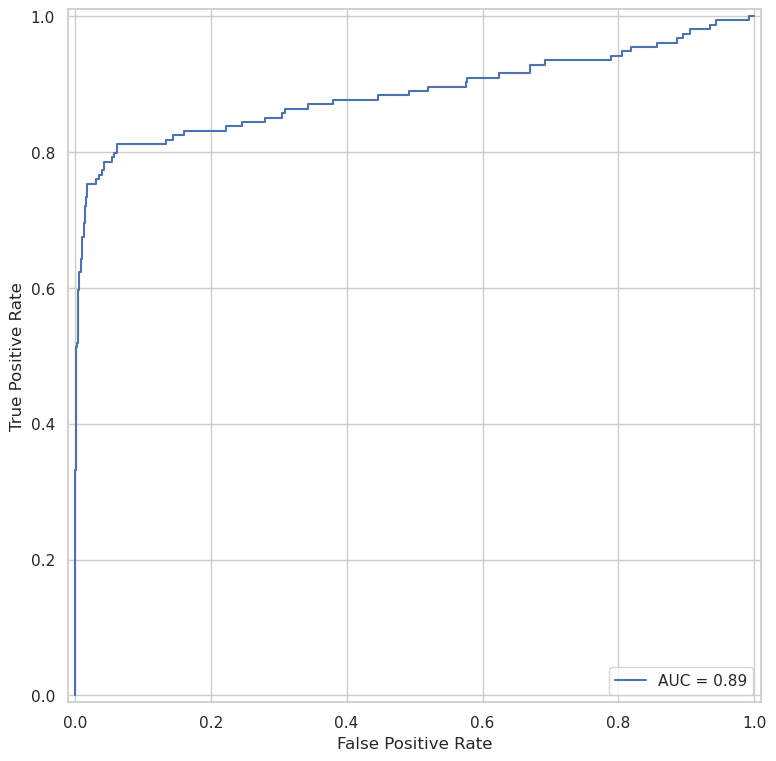

In [57]:
y_prob = gscv.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

Как будто с дефолтными параметрами лучше, но скорее всего дело в кросс-валидации.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

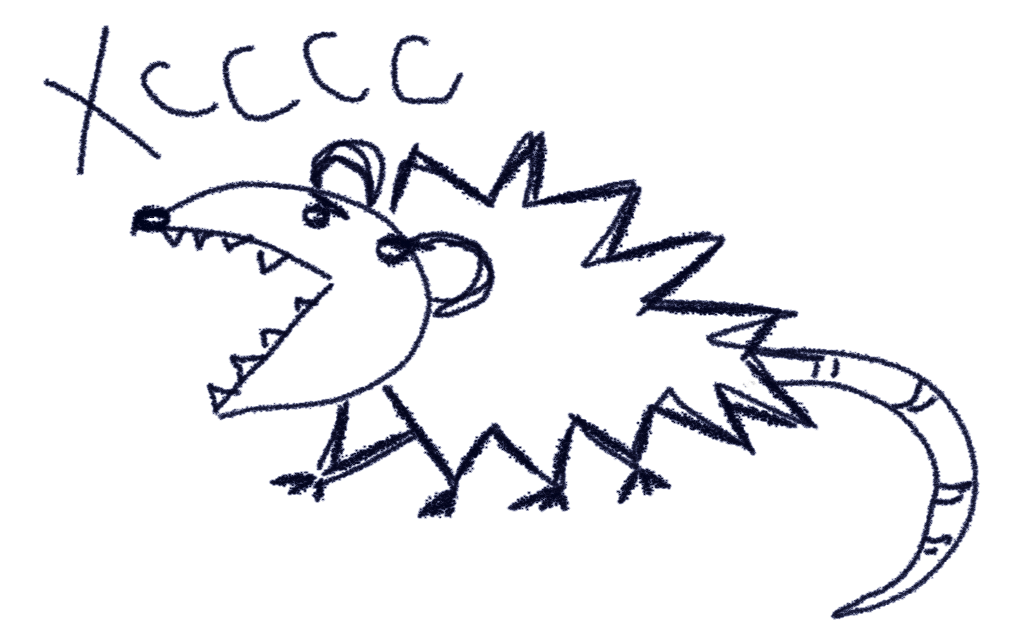

In [59]:
Image("../data_folder/raw_data/Витек.png")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Я не умею рисовать, но я попыталась нарисовать опоссума) Это мое тотемное животное, которое работает и орет.

Честно говоря, я очень долго прокрастинировала перед этим заданием, мне было бы психологически намного легче к нему приступить, если бы не ажиотаж вокруг него. А потом я была очень зла на себя потому, что не успевала все доделать, что хотела. Надеюсь в следующем году вместо "одна девочка говорила, что задание на нее давило психологически" кто-то скажет "вот была студентка, которая очень пожалела, что не начала задание раньше и не успела потестить все, что хотела".